In [1]:
#Obective 1: calculcate form factor

#Objective x: Calcualte dR/dE

In [2]:
#Imports
from mpmath import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import curve_fit
from scipy.special import erf

from numpy import vectorize


%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

print("Starting notebook....")


Populating the interactive namespace from numpy and matplotlib
Starting notebook....


/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand', 'cbrt', 'cosh', 'ldexp', 'hypot', 'cond', 'diff', 'inf', 'tan', 'polyval', 'plot', 'isnan', 'cholesky', 'matrix', 'fabs', 'floor', 'diag', 'nan', 'sqrt', 'frexp', 'degrees', 'zeros', 'pi', 'log10', 'sin', 'conj', 'binomial', 'polar', 'eig', 'power', 'eye', 'cos', 'ceil', 'beta', 'ones', 'isinf', 'linspace', 'sinh', 'sign', 'sinc', 'log', 'expm1', 'qr', 'e', 'tanh', 'svd', 'det', 'radians', 'arange', 'eigh', 'norm', 'fmod', 'dirichlet', 'exp', 'isfinite', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
#Global variables

#general
pi = 3.14159265359
c = 299792458 #m/s
h_bar = 6.582119569e-16 #eV/s
h_Js = 6.62607004e-34 #Js = m2 kg / s
h_eVs=4.135667696e-34 #eVs
h_GeVs=4.135667696e-43 #GeVs

convert_GeVtokg = 1.60218e-10/pow(c,2)

#Form factor
M_t_GeV = 122. #GeV (Xenon target mass)
M_t_keV = 122. *1000000. #keV
A_AMU = 131.293#131. #AMU (Xenon target mass)

#Cross-section limits from XENON1t data
Xe1t_WIMP_mass_array = np.asarray([5.93, 6.24, 6.49, 6.76, 7.17, 7.52, 7.90, 8.30, 8.91, 9.86, 10.99, 12.12, 13.59, 14.79, 16.37, 18.37, 20.67, 23.25, 26.41, 30.05, 33.10, 37.58, 42.98, 49.37, 55.67, 63.36, 71.10, 86.02, 105.30, 139.97, 172.56, 232.63, 288.15, 363.71, 475.55, 630.62, 816.83, 963.01])
Xe1t_CrossSection_array = np.asarray([2.34E-44, 1.70E-44, 1.13E-44, 7.53E-45, 4.58E-45, 3.21E-45, 2.26E-45, 1.61E-45, 1.03E-45, 5.75E-46, 3.45E-46, 2.30E-46, 1.50E-46, 1.15E-46, 8.70E-47, 6.66E-47, 5.46E-47, 4.82E-47, 4.39E-47, 4.25E-47, 4.25E-47, 4.47E-47, 4.79E-47, 5.29E-47, 5.81E-47, 6.51E-47, 7.06E-47, 8.46E-47, 1.01E-46, 1.29E-46, 1.57E-46, 2.09E-46, 2.62E-46, 3.23E-46, 4.23E-46, 5.67E-46, 7.33E-46, 8.67E-46] )     

#Cross-section
M_nucleon_GeV = .9385 #GeV

#dR/dE
DMdensity_GeVpcm3 = 0.3 #Gev/cm^3 (typically 0.3 Gev/cm^3)

#velocity
v_esc_kmps = 544. #km/s
v_0_kmps = 220. #km/s
v_earth_kmps = 244. #km/s 

y = v_earth_kmps/v_0_kmps #Used in truncated integral
z = v_esc_kmps/v_0_kmps #Used in truncated integral

N_escape = erf(z)-2.*z*np.exp(-(pow(z,2.)))/pow(pi,.5)
con = 1./(2.*N_escape*v_0_kmps*y)


LZ_volume_m3 = pi*pow(.688, 2)*1.321


In [4]:
#Functions

#lewin96
def Getq(E_R_keV, A):
    q = (6.92e-3)*pow(A,.5)*pow(E_R_keV,.5)#*r_n_fm#
    return q#pow(2*M_t_GeV*E_R_keV, .5)

#Get SI Form Factor #Olincna+ Lewin96
def GetFormFactor2_SI(E_R_keV, A):
    a_fm=.52 #fm
    s_fm=.9 #fm
    c_fm = 1.23*pow(A, 1./3.) - .6 # fm
    q = Getq(E_R_keV, A)
    x = q*r_n_fm
    part_1 = (3.*(np.sin(x) - x*np.cos(x)))  /  pow(x,3.)
    part_2 = np.exp( -1.*pow(q,2)*pow(s_fm,2*s_fm) )
    return pow(part_1,2.)*part_2

#BILLY
#def GetFormFactor2_SI(E_R_keV, A):
#    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
#    q = math.sqrt(2*M_Target_GeV*E_R_keV*1e-6)
#    #print "Mass = ", mass_WIMP/1e9, " GeV. Energy = ", energy/1e3," keV"
#    #Get nuclear radius (r_n) #Olinca + Lewin96
#    a=.52 #fm
#    s=.9 #fm
#    c_fm = 1.23*pow(A_AMU, 1./3.) - .6 # fm
#    #print "c_fm = "+str(c_fm)
#    r_n = pow(  pow(c_fm,2) + (7./3.)*pow(pi,2)*pow(a,2) - 5.*pow(s,2)  ,.5) #fm
##
#    qr = q*r_n/(h_GeVs*c)
#    qs = q*s/h_GeVs*c
#    j_1 = math.sin(qr)/pow(qr,2) - math.cos(qr)/qr
#    t1 = pow((3*j_1)/qr,2)
#    t2 = math.exp(-(pow(qs,2)))
#    F2_si = t1*t2;
#    return F2_si
vGetFormFactor2_SI = vectorize(GetFormFactor2_SI)

#Fit linear line
def fit_linfunc(x, a, b):
    return a*x + b

#Using XENON1t data
def Interpolate_Xsection(WIMP_mass_in):
    if WIMP_mass_in < min(Xe1t_WIMP_mass_array):
        #print "WIMP mass too low: "+str(WIMP_mass_in)
        popt, pcov = curve_fit( fit_linfunc, [Xe1t_WIMP_mass_array[0], Xe1t_WIMP_mass_array[1]], [Xe1t_CrossSection_array[0],Xe1t_CrossSection_array[1]] ) # your data x, y to fit
        return popt[0]*WIMP_mass_in + popt[1]


    elif WIMP_mass_in > max(Xe1t_WIMP_mass_array) and WIMP_mass_in < 999.:
        popt, pcov = curve_fit( fit_linfunc, [Xe1t_WIMP_mass_array[-2], Xe1t_WIMP_mass_array[-1]], [Xe1t_CrossSection_array[-2],Xe1t_CrossSection_array[-1]] ) # your data x, y to fit
        #print str(Xe1t_WIMP_mass_array[-1])+" < "+str(WIMP_mass_in)+" < "+str(1000)
        #print popt
        #print str(Xe1t_CrossSection_array[-1])+" < "+str(popt[0]*WIMP_mass_in + popt[1])+" < "+"\n"  
        return popt[0]*WIMP_mass_in + popt[1]
    elif WIMP_mass_in > 999.:
        #print "WIMP mass too high: "+str(WIMP_mass_in)
        return 999
    else:
        for i in range(0,len(Xe1t_WIMP_mass_array)-1):
            if WIMP_mass_in <= Xe1t_WIMP_mass_array[i+1] and WIMP_mass_in >= Xe1t_WIMP_mass_array[i]:
                popt, pcov = curve_fit( fit_linfunc, [Xe1t_WIMP_mass_array[i], Xe1t_WIMP_mass_array[i+1]], [Xe1t_CrossSection_array[i],Xe1t_CrossSection_array[i+1]] ) # your data x, y to fit
                #print str(Xe1t_WIMP_mass_array[i])+" < "+str(WIMP_mass_in)+" < "+str(Xe1t_WIMP_mass_array[i+1])
                #print popt
                #print str(Xe1t_CrossSection_array[i])+" < "+str(popt[0]*WIMP_mass_in + popt[1])+" < "+str(Xe1t_CrossSection_array[i+1])+"\n"
                return popt[0]*WIMP_mass_in + popt[1]
vInterpolate_Xsection = vectorize(Interpolate_Xsection)


# -Get Form factor using Lewin96

In [5]:
#Get nuclear radius (r_n) #Olinca + Lewin96
a_fm=.52 #fm
s_fm=.9 #fm
c_fm = 1.23*pow(A_AMU, 1./3.) - .6 # fm
print "c_fm = "+str(c_fm)

r_n_fm = pow(  pow(c_fm,2) + (7./3.)*pow(pi,2)*pow(a_fm,2) - 5.*pow(s_fm,2)  ,.5) #fm

print "r_n_fm: "+str(r_n_fm)+"\tTHIS LOOKS OK ... https://www-nds.iaea.org/radii/"

###Get nuclear radius #TF
##R_fm = pow(A_AMU, 1./3.)*1.2 #fm
##print "R_fm = "+str(R_fm)
##s_fm = 1. #fm
##r_n_fm = pow(  R_fm*R_fm-5*s_fm*s_fm  ,.5)
##print "r_n_fm = "+str(r_n_fm)


c_fm = 5.65152015103
r_n_fm: 5.84095389649	THIS LOOKS OK ... https://www-nds.iaea.org/radii/


210000
210000


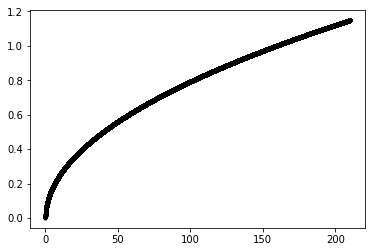

In [6]:
#CHECK Momentum transfer #Lewin 96


#Make array of recoil energies to plot
E_R_keV_array = np.arange(0, 210, .001)
q_array = Getq(E_R_keV_array, A_AMU)

print len(E_R_keV_array)
print len(q_array)
figure(1)
plt.plot(E_R_keV_array, q_array, '.k')
#plt.yscale('log')

/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 <a list of 13 Text yticklabel objects>)

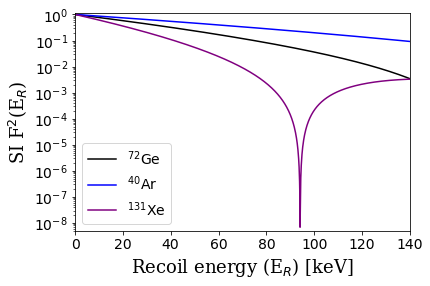

In [7]:
#Obective 1: calculcate form factor  
E_R_keV_array = np.arange(0,150,.1)

FormFactor_SI_array = vGetFormFactor2_SI(E_R_keV_array, A_AMU)
Argon_Array = GetFormFactor2_SI(E_R_keV_array, 39.948)
Ge_Array = GetFormFactor2_SI(E_R_keV_array, 72.64)
#Gold_Array = GetFormFactor2_SI(E_R_keV_array, 196.967)

#Plot form factor
figure(1)
plt.plot(E_R_keV_array, Ge_Array, '-k', label="$^{72}$Ge")
plt.plot(E_R_keV_array, Argon_Array, '-b', label="$^{40}$Ar")
plt.plot(E_R_keV_array, FormFactor_SI_array, 'purple', label="$^{131}$Xe")
#plt.plot(E_R_keV_array, Gold_Array, '-r', label="$^{197}Au$")
plt.yscale('log')
plt.ylim(5e-9,1.1)
plt.xlim(0,140)
plt.xlabel("Recoil energy (E$_R$) [keV]", fontsize=18,family='serif')
plt.ylabel('SI F$^2$(E$_R$)', fontsize=18,family='serif')
pyplot.legend(loc='best', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# -Get Cross-Section Limits from XENON1t data

/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


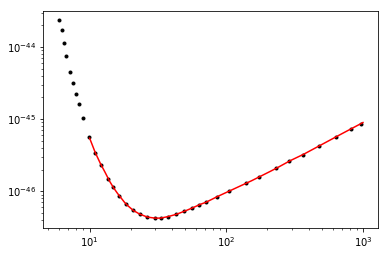

In [8]:
#CHECK: cross-section limits from XENON1t data

x_data = np.arange(10, 1000, 1)
y_data = vInterpolate_Xsection(x_data)

figure(1)
plt.plot(Xe1t_WIMP_mass_array, Xe1t_CrossSection_array, '.k')
plt.plot(x_data, y_data, '-r')
plt.xscale('log')
plt.yscale('log')

In [9]:
#Convert WIMP-nucleon Xsection into zero-momentum WIMP-nucleus Xsection
def GetSigma_0(A, M_WIMP_GeV):
    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)
    mu_n = M_nucleon_GeV*M_WIMP_GeV / (M_nucleon_GeV + M_WIMP_GeV)

    sigma_0 = pow(A,2.)*pow(mu_N/mu_n ,2.)*Interpolate_Xsection(M_WIMP_GeV)
    return sigma_0

vGetSigma_0 = vectorize(GetSigma_0)

sigma_0 = GetSigma_0(A_AMU, 50.)
print "\nsigma_0 = "+str(sigma_0)


sigma_0 = 1.3668168724352131e-39


# -Calculate velocity distribution

466.841262099


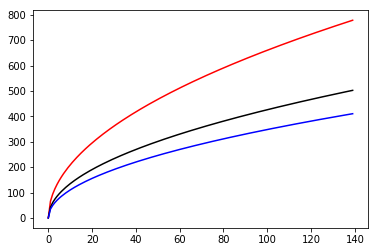

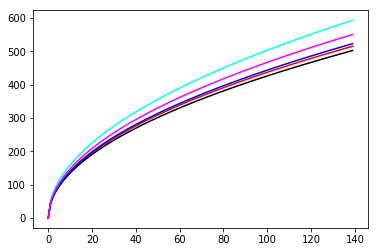

In [10]:
#Deterine min velocity #Billy
def VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV):
    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)
    v_min_kmps = pow( (M_Target_GeV*E_R_keV*1e-6)/(2.*pow(mu_N,2)),.5 )*c/1000. #/1000 m/s -> to km/s
    return v_min_kmps

M_Target_GeV = 122.
M_WIMP_GeV = 50.
E_R_keV = 50.
#r_parameter = 4.*M_Target_GeV*M_WIMP_GeV / pow(M_Target_GeV + M_WIMP_GeV,2.)

print VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV)

#E_0_keV =.5* M_WIMP_GeV*1e6*pow(v_0_kmps,2.) #Lewin96 pg 8 eqn 3.8 / 3.9
#v_min_kmps = pow( E_R_keV/(E_0_keV*r_parameter),.5 ) #m/s
#print v_min_kmps


x_data = np.arange(0,140,1)
y_data_50 = VelocityMin(122., 50., x_data)
y_data_100 = VelocityMin(122., 100., x_data)
y_data_150 = VelocityMin(122., 150., x_data)

figure(1)
plt.plot(x_data, y_data_50, 'r')
plt.plot(x_data, y_data_100, 'k')
plt.plot(x_data, y_data_150, 'b')

x_data = np.arange(0,140,1)
y_data_30 = VelocityMin(30., 100., x_data)
y_data_61 = VelocityMin(61., 100., x_data)
y_data_122 = VelocityMin(122., 100., x_data)
y_data_183 = VelocityMin(183., 100., x_data)
y_data_244 = VelocityMin(244., 100., x_data)

figure(2)
plt.plot(x_data, y_data_30, 'cyan')
plt.plot(x_data, y_data_61, 'r')
plt.plot(x_data, y_data_122, 'k')
plt.plot(x_data, y_data_183, 'b')
plt.plot(x_data, y_data_244, 'magenta')



In [11]:
print c

299792458


0.0009165648173090681


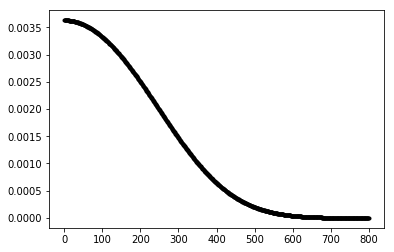

In [12]:
#Calculate Velocity integral #Billy
def VelocityIntegral(v_min,v_0):
    x = v_min /v_0  #Used in truncated integral
    if x < abs(y-z):
        #print str(x)+" < "+str(abs(y-z))
        fv  = con*(erf(x+y) - erf(x-y)-4./pow(pi,.5)*y*np.exp(-pow(z,2)))
    elif (x >= abs(y-z) and x < (y+z)):
        #print str(y+z)+" < "+str(x)+" < "+str(abs(y-z))
        fv = con*(erf(z) - erf(x-y)-2./pow(pi,.5)*(y+z-x)*np.exp(-pow(z,2)))
    else:
        #print "else: "+str(x)
        fv = 0
    return(fv)
vVelocityIntegral = vectorize(VelocityIntegral)

M_Target_GeV = 122.
M_WIMP_GeV =50. 
E_R_keV = 30.

v_min_kmps = VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV)
print VelocityIntegral(v_min_kmps, v_0_kmps)

x_data = np.arange(0,800,1)
y_data = vVelocityIntegral(x_data, v_0_kmps)
figure(1)
plt.plot(x_data, y_data, '.k')


In [13]:
print vVelocityIntegral(300, v_0_kmps)

0.0014705350357319107


In [14]:
##Get velocity integral
#def CalculateVelocityIntegral(E_R_keV, M_WIMP_GeV, A):
#    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
#
#    #E_0_GeV = .5*M_WIMP_GeV*pow(v_0_kmps,2) #Lewin96 pg 8 eqn 3.8 / 3.9
#    E_0_keV =.5* M_WIMP_GeV*1e6*pow(v_0_kmps,2) #Lewin96 pg 8 eqn 3.8 / 3.9
#
#    r_parameter = 4*M_Target_GeV*M_WIMP_GeV / pow(M_Target_GeV + M_WIMP_GeV,2)
#
#    #velocity of WIMP with energy E_min
#    #v_min_kmps = pow( E_R_keV/(E_0_keV*r_parameter),.5) #m/s
#    v_min_kmps = VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV)
#    
#    #Minimum energy of WIMP that could cause the obsered recoil
#    E_min_keV = E_R_keV / r_parameter
#
#    #print "E_0_GeV = "+str(E_0_GeV)
#    #print "E_0_keV = "+str(E_0_keV)
#    #print "r_parameter = "+str(r_parameter)
#    #print "\nv_min_kmps = "+str(v_min_kmps)
#    #print "\nE_min_keV = "+str(E_min_keV)
#    
#    #Calculate velocity integral #WL thesis
#    velocity_integral = (pow(pi,.5)/4) *( erf((v_min_kmps+v_earth_kmps)/v_0_kmps) - erf((v_min_kmps-v_earth_kmps)/v_0_kmps) ) - np.exp(-1.*pow(v_esc_kmps,2)/pow(v_0_kmps,2))
#
#    return velocity_integral
#vCalculateVelocityIntegral = vectorize(CalculateVelocityIntegral)
#
#velocity_integral = CalculateVelocityIntegral(100., 30., A_AMU)
#print velocity_integral


140


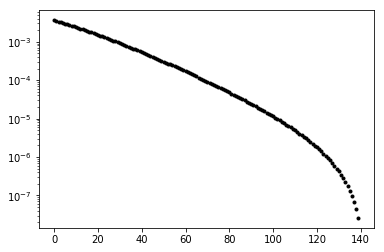

In [15]:
#Plot velocity integral for a range of E_R and a range of M_WIMP
M_WIMP_GeV=50.
x_data = np.arange(0, 140, 1)
pre_y_data = VelocityMin(M_Target_GeV, M_WIMP_GeV, x_data)
#vCalculateVelocityIntegral(x_data, 30., A_AMU)
y_data = vVelocityIntegral(pre_y_data, v_0_kmps)

print len(y_data)
figure(1)
plt.plot(x_data, y_data, '.k')
plt.yscale('log')

#x_data = np.arange(0, 100000, 10000)
#pre_y_data = VelocityMin(M_Target_GeV, x_data, 100.)
##vCalculateVelocityIntegral(x_data, 30., A_AMU)
#y_data = vVelocityIntegral(pre_y_data, v_0_kmps)

#figure(2)
#plt.plot(x_data, y_data, '.k')

In [16]:
##Calculate velocity distribution
#print "x = "+str(x)
#print "y = "+str(y)
#print "z = "+str(z)
#
#print "\npow(pow(y-z,2),.5) = "+str(pow(pow(y-z,2),.5))
#
#if z<y and x< pow(pow(y-z,2),.5):
#    print "condition 1"
#if z>y and x> pow(pow(y-z,2),.5):
#    print "condition 2"
#if x> pow(pow(y-z,2),.5) and x< pow(pow(y+z,2),.5):
#    print "condition 3"
#if y+z < x:
#    print "condition 4"

# - Calculate dR/dE

In [17]:
"""#Calculate dR/dE

def Get_dRdE(A, M_WIMP_GeV, E_R_keV, sigma_0_cm2):
    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)
    v_min_kmps = VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV)
    
    p_1 = DMdensity_GeVpcm3*sigma_0_cm2/( 2*M_WIMP_GeV*pow(mu_N,2) )
    p_1_corrected = p_1 *10.*c*c*c/h_bar
    p_2 = vGetFormFactor2_SI(E_R_keV, A)
    p_3 = VelocityIntegral(v_min_kmps, v_0_kmps)

    #print str(E_R_keV)+"\t"+str(p_1_corrected)+"\t"+str(p_2)+"\t"+str(p_3)
    dRdE = p_1_corrected*p_2* p_3
    return dRdE
vGet_dRdE = vectorize(Get_dRdE)

#TEST
M_WIMP_GeV = 50.
E_R_keV = 100.

dRdE = vGet_dRdE(A_AMU, M_WIMP_GeV, E_R_keV, 1e-36)
print "\ndR/dE = "+str(dRdE)
"""

'#Calculate dR/dE\n\ndef Get_dRdE(A, M_WIMP_GeV, E_R_keV, sigma_0_cm2):\n    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)\n    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)\n    v_min_kmps = VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV)\n    \n    p_1 = DMdensity_GeVpcm3*sigma_0_cm2/( 2*M_WIMP_GeV*pow(mu_N,2) )\n    p_1_corrected = p_1 *10.*c*c*c/h_bar\n    p_2 = vGetFormFactor2_SI(E_R_keV, A)\n    p_3 = VelocityIntegral(v_min_kmps, v_0_kmps)\n\n    #print str(E_R_keV)+"\t"+str(p_1_corrected)+"\t"+str(p_2)+"\t"+str(p_3)\n    dRdE = p_1_corrected*p_2* p_3\n    return dRdE\nvGet_dRdE = vectorize(Get_dRdE)\n\n#TEST\nM_WIMP_GeV = 50.\nE_R_keV = 100.\n\ndRdE = vGet_dRdE(A_AMU, M_WIMP_GeV, E_R_keV, 1e-36)\nprint "\ndR/dE = "+str(dRdE)\n'

In [18]:
#Calculate dR/dE

def Get_dRdE(A, M_WIMP_GeV, E_R_keV, sigma_0_cm2):
    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)
    v_min_kmps = VelocityMin(M_Target_GeV, M_WIMP_GeV, E_R_keV)
    
    mu_n = M_Target_GeV*.938 / (M_Target_GeV + .938)
    sigma_A_cm2 = A*A*sigma_0_cm2*mu_N*mu_N/(mu_n * mu_n)
    
    p_1 = DMdensity_GeVpcm3*sigma_A_cm2/( 2*M_WIMP_GeV*pow(mu_N,2) )
    p_1_corrected = p_1 *c*c*c*c#*c*c/h_bar#
    p_2 = vGetFormFactor2_SI(E_R_keV, A)
    p_3 = VelocityIntegral(v_min_kmps, v_0_kmps)

    #print str(E_R_keV)+"\t"+str(p_1_corrected)+"\t"+str(p_2)+"\t"+str(p_3)
    dRdE = p_1_corrected*p_2* p_3
    return dRdE
vGet_dRdE = vectorize(Get_dRdE)

#TEST
M_WIMP_GeV = 50.
E_R_keV = 100.

dRdE = vGet_dRdE(A_AMU, M_WIMP_GeV, E_R_keV, 1e-36)
print "\ndR/dE = "+str(dRdE)


dR/dE = 1.1461727341842478e-09


In [19]:
#TEST
M_WIMP_GeV = 100.
E_R_keV = 1.

dRdE = vGet_dRdE(A_AMU, M_WIMP_GeV, E_R_keV, 1e-45)
print "\ndR/dE = "+"{:e}".format(dRdE)

print "\n{:e}".format(1./(c*c*c*c))
print h_bar/(c*c)


dR/dE = 8.214063e-13

1.237990e-34
7.3235957074e-33


/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


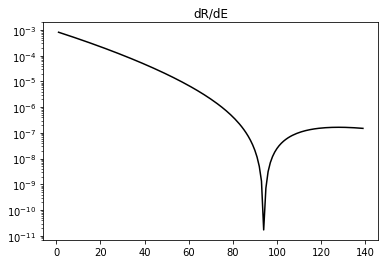

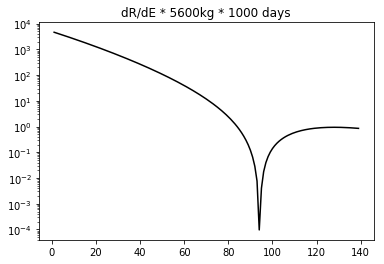

In [20]:
### CHECK: PLOT
x_data = np.arange(0,140,1)
y_data_list = []

for i in range(0, len(x_data)):
    y_data_list.append( Get_dRdE(A_AMU, M_WIMP_GeV, x_data[i],1e-36) )#*LZ_volume_m3*2880.*1000. )

y_data = np.asarray(y_data_list)

figure(1)
plt.title("dR/dE")
plt.plot(x_data, y_data, 'k')
plt.yscale('log')

y_data_list = []

for i in range(0, len(x_data)):
    y_data_list.append( Get_dRdE(A_AMU, M_WIMP_GeV, x_data[i],1e-36 ) *LZ_volume_m3*2880.*1000. )

y_data = np.asarray(y_data_list)
                       
figure(2)
plt.title("dR/dE * 5600kg * 1000 days")
plt.plot(x_data, y_data, 'k')
plt.yscale('log')
#plt.xlim(0,140)
#plt.ylim(1e-3,1e6)



# - Check dR/dE against IBles thesis (pg55)

95
95




1.0715617319965978
1.1947829161401275
1.1370410891427005


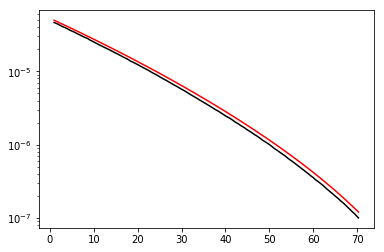

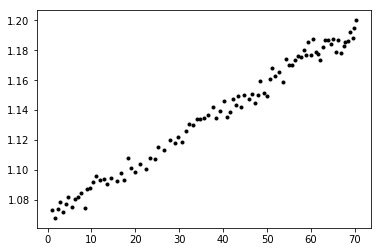

In [21]:
#Ibles DR/dE [/kg/keV/day]
Ibles_x_keV_list = [9.758118E-01, 1.748329E+00, 2.358212E+00, 2.927435E+00, 3.577976E+00, 4.187859E+00, 4.757082E+00, 5.570259E+00, 6.261459E+00, 6.912000E+00, 7.725176E+00, 8.579012E+00, 9.107576E+00, 9.717459E+00, 1.044932E+01, 1.114052E+01, 1.195369E+01, 1.280753E+01, 1.349873E+01, 1.455586E+01, 1.585694E+01, 1.667012E+01, 1.748329E+01, 1.841845E+01, 1.903922E+01, 1.998039E+01, 2.100000E+01, 2.235294E+01, 2.325490E+01, 2.447059E+01, 2.521569E+01, 2.658824E+01, 2.788235E+01, 2.898039E+01, 2.982353E+01, 3.072549E+01, 3.156863E+01, 3.231373E+01, 3.323529E+01, 3.409804E+01, 3.484314E+01, 3.564706E+01, 3.658824E+01, 3.768627E+01, 3.835294E+01, 3.925490E+01, 4.009804E+01, 4.088235E+01, 4.164706E+01, 4.223529E+01, 4.290196E+01, 4.343137E+01, 4.413725E+01, 4.478431E+01, 4.586275E+01, 4.658824E+01, 4.727451E+01, 4.788235E+01, 4.849020E+01, 4.925490E+01, 5.001961E+01, 5.074510E+01, 5.121569E+01, 5.190196E+01, 5.280392E+01, 5.360784E+01, 5.429412E+01, 5.503922E+01, 5.574510E+01, 5.647059E+01, 5.711765E+01, 5.772549E+01, 5.835294E+01, 5.894118E+01, 5.939216E+01, 5.992157E+01, 6.047059E+01, 6.107843E+01, 6.162745E+01, 6.215686E+01, 6.264706E+01, 6.313725E+01, 6.386275E+01, 6.449020E+01, 6.505882E+01, 6.566667E+01, 6.619608E+01, 6.688235E+01, 6.741176E+01, 6.784314E+01, 6.833333E+01, 6.890196E+01, 6.947059E+01, 6.990196E+01, 7.029412E+01]       
Ibles_y_keV_list = [4.628483E-05, 4.426345E-05, 4.233059E-05, 4.060281E-05, 3.917787E-05, 3.746708E-05, 3.593781E-05, 3.426616E-05, 3.257535E-05, 3.115283E-05, 2.943981E-05, 2.807038E-05, 2.676494E-05, 2.567246E-05, 2.433315E-05, 2.313246E-05, 2.192560E-05, 2.065838E-05, 1.975623E-05, 1.828492E-05, 1.672283E-05, 1.570953E-05, 1.488993E-05, 1.374015E-05, 1.322361E-05, 1.237861E-05, 1.143891E-05, 1.038998E-05, 9.656536E-06, 8.821571E-06, 8.281654E-06, 7.479185E-06, 6.735136E-06, 6.197098E-06, 5.784496E-06, 5.407106E-06, 5.025423E-06, 4.717845E-06, 4.384805E-06, 4.075282E-06, 3.836852E-06, 3.591692E-06, 3.319042E-06, 3.014717E-06, 2.871112E-06, 2.649363E-06, 2.451770E-06, 2.314956E-06, 2.160832E-06, 2.037342E-06, 1.929190E-06, 1.832038E-06, 1.732294E-06, 1.623944E-06, 1.477163E-06, 1.378819E-06, 1.301883E-06, 1.225720E-06, 1.149056E-06, 1.077182E-06, 1.004024E-06, 9.278144E-07, 8.810922E-07, 8.283549E-07, 7.567384E-07, 7.033218E-07, 6.480751E-07, 6.031949E-07, 5.614235E-07, 5.195540E-07, 4.849654E-07, 4.552856E-07, 4.243665E-07, 3.995405E-07, 3.777913E-07, 3.592812E-07, 3.353637E-07, 3.157443E-07, 2.972732E-07, 2.810902E-07, 2.638886E-07, 2.484516E-07, 2.282792E-07, 2.124714E-07, 1.980425E-07, 1.853896E-07, 1.725524E-07, 1.596841E-07, 1.488402E-07, 1.405363E-07, 1.319361E-07, 1.219222E-07, 1.134796E-07, 1.065353E-07, 1.005918E-07]       

#Xsection: 1e-45
#Convert WIMP-nucleon Xsection into zero-momentum WIMP-nucleus Xsection
def IblesGetSigma_0(A, M_WIMP_GeV):
    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)
    mu_n = M_nucleon_GeV*M_WIMP_GeV / (M_nucleon_GeV + M_WIMP_GeV)

    sigma_0 = pow(A,2.)*pow(mu_N/mu_n ,2.)*1e-45
    return sigma_0

vIblesGetSigma_0 = vectorize(IblesGetSigma_0)


sigma_0 = IblesGetSigma_0(131.3, 100)
peter_ydata = vGet_dRdE(131.3, 100, np.asarray(Ibles_x_keV_list),sigma_0 )#/1.2800423761797842e-35
#peter_ydata = vGet_dRdE(131.3, 100, np.asarray(Ibles_x_keV_list),1e-45 )#/1.2800423761797842e-35



figure(1)
plt.plot(Ibles_x_keV_list, np.asarray(Ibles_y_keV_list), 'k')
plt.plot(Ibles_x_keV_list, peter_ydata, 'r')
plt.yscale('log')

figure(2)
plt.plot(Ibles_x_keV_list, peter_ydata/np.asarray(Ibles_y_keV_list), '.k')
#plt.plot(Ibles_x_keV_list, peter_ydata, 'k')
#plt.yscale('log')


print len(peter_ydata)
print len(Ibles_y_keV_list)

temp_list = []
print "\n"
for i in range(0, len(Ibles_y_keV_list)):
    #print str(peter_ydata[i])+" / "+str(Ibles_y_keV_list[i])+" = "+str(peter_ydata[i] / Ibles_y_keV_list[i])
    temp_list.append(peter_ydata[i] / Ibles_y_keV_list[i])
    
min_val = min(temp_list)
max_val = max(temp_list)

temp2_list = []
for element in temp_list:
    if element == min_val or element ==max_val:
        continue
    else:
        temp2_list.append(element)
print "\n"
print min(temp2_list)
print max(temp2_list)
print np.mean(temp2_list)

#print "\nCorrection factor must be: *10.*c*c*c/h_bar"

# -Check dR/dE against Theresa's plot [counter/keV/t/year]


sigma_0 = 2.55862387202e-39
0.039024813848604005
124.52217690370236
5.589908712759554


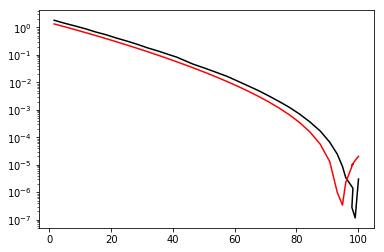

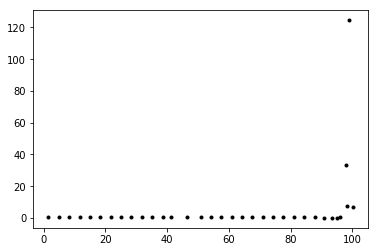

In [22]:
Theresa_x_keV_list = [1.527163E+00, 4.892165E+00, 8.257167E+00, 1.162217E+01, 1.498717E+01, 1.835217E+01, 2.171717E+01, 2.508217E+01, 2.844718E+01, 3.181218E+01, 3.517718E+01, 3.854218E+01, 4.129536E+01, 4.649582E+01, 5.090091E+01, 5.414355E+01, 5.750855E+01, 6.087356E+01, 6.423856E+01, 6.760356E+01, 7.096856E+01, 7.433356E+01, 7.769856E+01, 8.106357E+01, 8.442857E+01, 8.779357E+01, 9.085266E+01, 9.329994E+01, 9.498244E+01, 9.605312E+01, 9.837803E+01, 9.804153E+01, 9.911221E+01, 1.001829E+02]      
Theresa_y_keV_list = [1.806888E+00, 1.407180E+00, 1.122670E+00, 8.885046E-01, 6.754511E-01, 5.367215E-01, 4.063833E-01, 3.164857E-01, 2.415659E-01, 1.785412E-01, 1.379310E-01, 1.032657E-01, 8.199863E-02, 4.608455E-02, 3.105759E-02, 2.285374E-02, 1.655478E-02, 1.124428E-02, 7.545673E-03, 5.084072E-03, 3.250946E-03, 2.037376E-03, 1.241369E-03, 7.006985E-04, 3.620093E-04, 1.684523E-04, 6.637934E-05, 2.438352E-05, 8.725190E-06, 3.418653E-06, 1.404967E-06, 2.824454E-07, 1.165303E-07, 3.013659E-06]

kgPERday_to_tPERyear = 1000.*365.25

#Xsection = 1e-46


#Convert WIMP-nucleon Xsection into zero-momentum WIMP-nucleus Xsection
def TheresaGetSigma_0(A, M_WIMP_GeV):
    M_Target_GeV = A*1.66054E-27*pow(c,2.)*6242000000000000000*pow(10,-9)
    mu_N = M_Target_GeV*M_WIMP_GeV / (M_Target_GeV + M_WIMP_GeV)
    mu_n = M_nucleon_GeV*M_WIMP_GeV / (M_nucleon_GeV + M_WIMP_GeV)

    sigma_0 = pow(A,2.)*pow(mu_N/mu_n ,2.)*1e-46
    return sigma_0

vTheresaGetSigma_0 = vectorize(TheresaGetSigma_0)

sigma_0 = TheresaGetSigma_0(A_AMU, 50.)
print "\nsigma_0 = "+str(sigma_0)


sigma_0 = GetSigma_0(131.3, 80)
peter_ydata = vGet_dRdE(131, 80, np.asarray(Theresa_x_keV_list),sigma_0 )*kgPERday_to_tPERyear #/ 1.541572281191767e-32
#peter_ydata = vGet_dRdE(131, 80, np.asarray(Theresa_x_keV_list),1e-46 )*kgPERday_to_tPERyear #/ 1.541572281191767e-32



figure(1)
plt.plot(Theresa_x_keV_list, np.asarray(Theresa_y_keV_list), 'k')
plt.plot(Theresa_x_keV_list, peter_ydata, 'r')
plt.yscale('log')

figure(2)
plt.plot(Theresa_x_keV_list, peter_ydata/np.asarray(Theresa_y_keV_list), '.k')
#plt.plot(Ibles_x_keV_list, peter_ydata, 'k')
#plt.yscale('log')

print min(peter_ydata/np.asarray(Theresa_y_keV_list))
print max(peter_ydata/np.asarray(Theresa_y_keV_list))
print np.mean(peter_ydata/np.asarray(Theresa_y_keV_list))


# -Make WIMP event rate plot 

A_AMU: 131.293
M_WIMP_GeV: 100.0
sigma_0: 5.823966785092493e-39




/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0, 140)

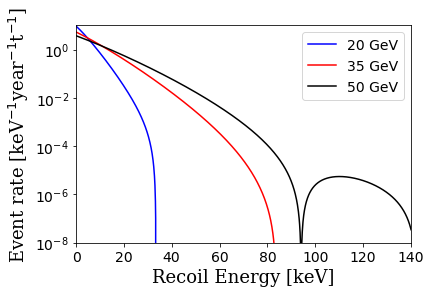

In [23]:
#PLOT: different WIMP masses

M_WIMP_GeV = 100.
sigma_0 = GetSigma_0(A_AMU, M_WIMP_GeV)

print "A_AMU: "+str(A_AMU)
print "M_WIMP_GeV: "+str(M_WIMP_GeV)
print "sigma_0: "+str(sigma_0)
print "\n"

x_data = np.arange(0,150,.1)
y_data_25 = vGet_dRdE(A_AMU, 20., x_data, sigma_0)*kgPERday_to_tPERyear
y_data_50 = vGet_dRdE(A_AMU, 35., x_data, sigma_0)*kgPERday_to_tPERyear
y_data_100 = vGet_dRdE(A_AMU, 50., x_data, sigma_0)*kgPERday_to_tPERyear

figure(1)
plt.plot(x_data, y_data_25, 'b', label='20 GeV')
plt.plot(x_data, y_data_50, 'r', label='35 GeV')
plt.plot(x_data, y_data_100,'k',label='50 GeV')

plt.yscale('log')
plt.xlabel('Recoil Energy [keV]', fontsize=18,family='serif')
plt.ylabel('Event rate [keV$^{-1}$year$^{-1}$t$^{-1}$]', fontsize=18,family='serif')
pyplot.legend(loc='best', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(1e-8,10)
plt.xlim(0,140)

In [24]:
print sigma_0

5.823966785092493e-39


A_AMU: 131.293
M_WIMP_GeV: 100.0
sigma_0: 5.823966785092493e-39




/cvmfs/sft.cern.ch/lcg/views/LCG_95/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0, 140)

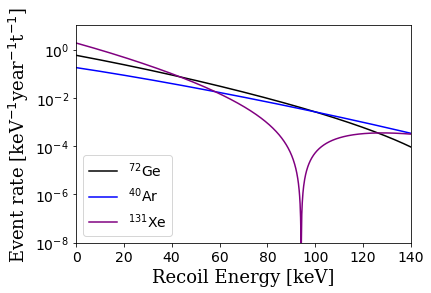

In [25]:
#PLOT: different WIMP masses

M_WIMP_GeV = 100.
sigma_0 = GetSigma_0(A_AMU, M_WIMP_GeV)

print "A_AMU: "+str(A_AMU)
print "M_WIMP_GeV: "+str(M_WIMP_GeV)
print "sigma_0: "+str(sigma_0)
print "\n"

y_data_Ge = vGet_dRdE(72.64, 100., x_data, sigma_0)*kgPERday_to_tPERyear
y_data_Ar = vGet_dRdE(39.948, 100., x_data, sigma_0)*kgPERday_to_tPERyear
y_data_131 = vGet_dRdE(A_AMU, 100., x_data, sigma_0)*kgPERday_to_tPERyear

figure(1)
plt.plot(x_data, y_data_Ge, 'k', label='$^{72}$Ge')
plt.plot(x_data, y_data_Ar, 'b', label='$^{40}$Ar')
plt.plot(x_data, y_data_131, 'purple', label='$^{131}$Xe')
plt.yscale('log')
plt.xlabel('Recoil Energy [keV]', fontsize=18,family='serif')
plt.ylabel('Event rate [keV$^{-1}$year$^{-1}$t$^{-1}$]', fontsize=18,family='serif')
pyplot.legend(loc='best', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(1e-8,10)
plt.xlim(0,140)